#Pixel Deflection - a simple transformation based defense

## Change local pixel arrangement and then denoise using wavelet transform

## Load the requirements

In [ ]:
!git clone https://github.com/iamaaditya/pixel-deflection.git

Cloning into 'pixel-deflection'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (96/96), 3.26 MiB | 1.94 MiB/s, done.


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint, uniform

### Load the classifier
Classifier can be easily changed to inception_v3, vgg19, xception, etc. [see this](https://github.com/iamaaditya/pixel-deflection/blob/master/main.py#L65)

In [ ]:
import keras.utils as image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')

In [ ]:
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img)
    true_label = img_path.split('/')[-1].split('_')[0]
    return img, true_label

In [ ]:
def visualize_classification(class_names, probs, image, true_class=-1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.sca(ax1)
    
    ax1.imshow(image.astype('uint8'))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Image')
    
    y_pos = np.arange(len(class_names))
    barlist = ax2.bar(y_pos, probs, align='center', alpha=0.5)
    if true_class >= 0 and true_class <= 4:
        barlist[true_class].set_color('g')
    ax2.set_xticks(y_pos, minor=False)
    ax2.set_xticklabels(class_names, minor=False, rotation='vertical')
    ax2.set_ylabel('Probability of given class')
    ax2.set_title('Classification')
   
    for bar in barlist:
        v = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., 1.02*v, '%.2f' % v, ha='center')

This classification function works for multiple images in a batch. However, visualization is limited to the first image in the batch.
See our GitHub code for better batch processing functions.

In [ ]:
def classify_images(images_arr, true_label, visualize=False):
    images = preprocess_input(np.stack(images_arr,axis=0))
    predictions = decode_predictions(model.predict(images),top=5)
    labels, class_names, probs = [], [], []
    for p in predictions:
        labels.append([i[0] for i in p])
        class_names.append([i[1] for i in p])
        probs.append([i[2] for i in p])
    
    if visualize:
        label_index = labels[0].index(true_label) if true_label in labels[0] else -1
        visualize_classification(class_names[0], probs[0], images_arr[0], label_index)
    
    return labels, class_names, probs

## Load and classify the original

35363/35363 [==============================] - 0s 0us/step


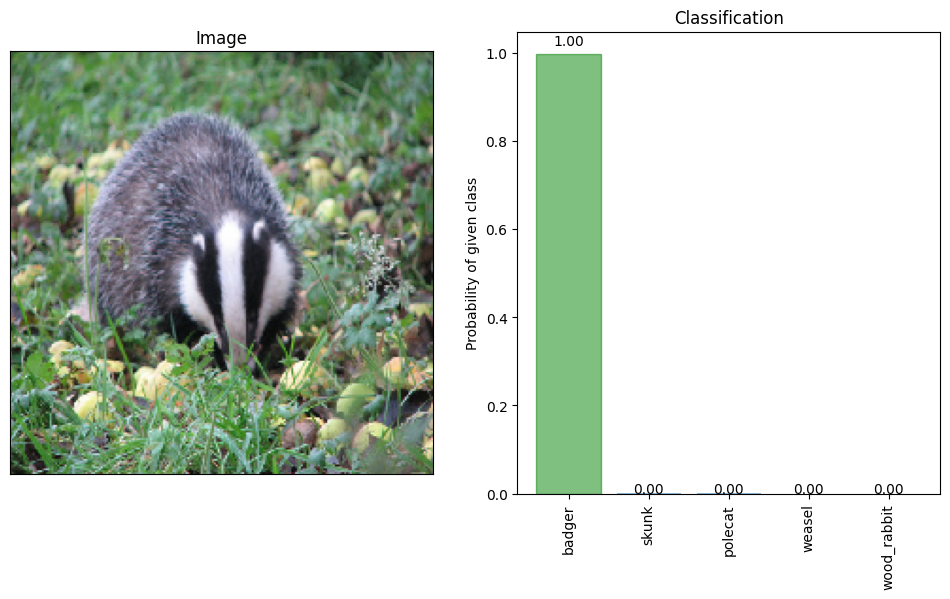

In [ ]:
img_clean, true_label = load_image('/content/pixel-deflection/originals/n02447366_00008562.png')
_ = classify_images([img_clean], true_label, visualize=True)

Green color bar indicates the 'true' class of the image. 
The image is correctly classified as **'badger'** with 100% confidence.

## Load and classify the adversarial image

1/1 [==============================] - 1s 1s/step


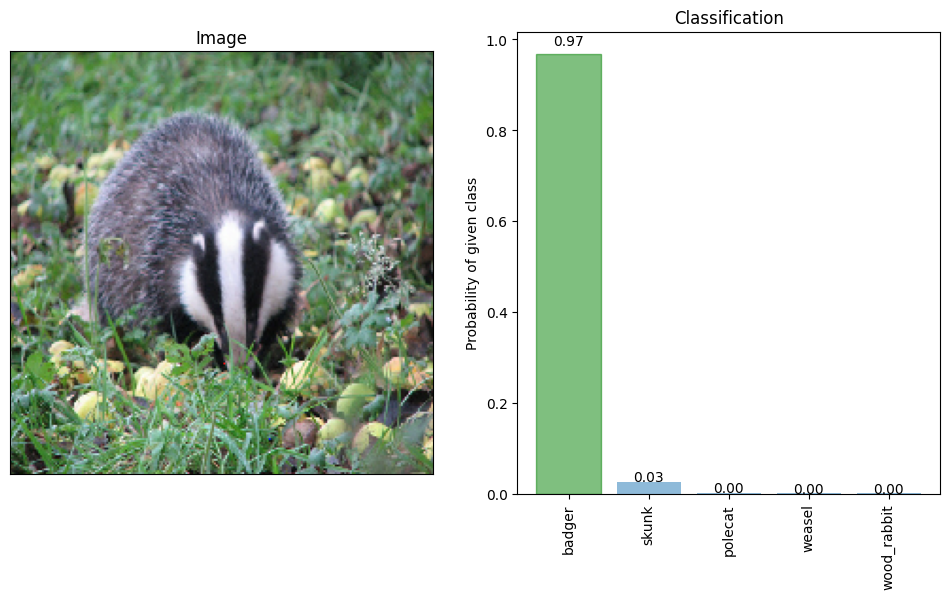

In [ ]:
img_adversary, true_label = load_image('/content/pixel-deflection/images/n02447366_00008562.png')
_ = classify_images([img_adversary], true_label, visualize=True)

The true class **'badger'** is now only 15% and __'skunk'__ is the most likely class with 59% classification.
This adversary was obtained using IGSM attack model.
# Pixel Deflection

In our paper, we use pixel deflection with an activation map, but first let's look at pixel deflection without any maps.

In [ ]:
def pixel_deflection_without_map(img, deflections, window):
    img = np.copy(img)
    H, W, C = img.shape
    while deflections > 0:
        #for consistency, when we deflect the given pixel from all the three channels.
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            while True: #this is to ensure that PD pixel lies inside the image
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            # calling pixel deflection as pixel swap would be a misnomer,
            # as we can see below, it is one way copy
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1
    return img

1/1 [==============================] - 0s 357ms/step


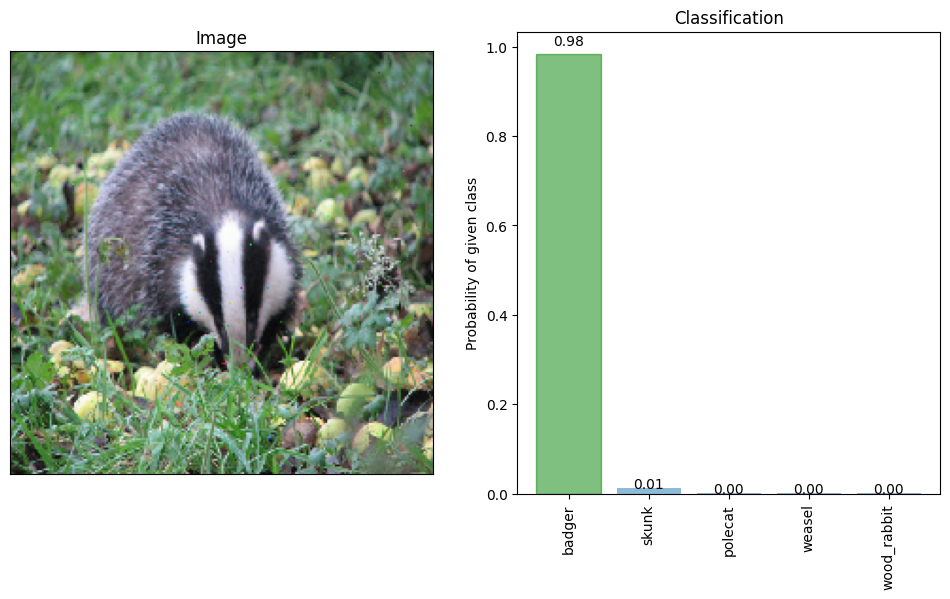

In [ ]:
# pixel deflection on adversarial image
img_deflected = pixel_deflection_without_map(img_adversary, deflections=200, window=10)
_ = classify_images([img_deflected], true_label, visualize=True)

Pixel Deflection is able to retrieve the original class of the image, although the confidence of the true class **badger** has gone down significantly when compared with the clean image -  from 99.7% to 52%.

### Let's see the pixels that were deflected.

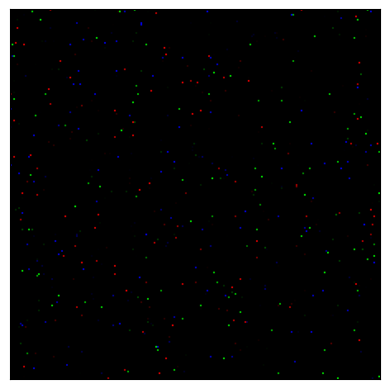

In [ ]:
# deflected pixels
diff = img_adversary - img_deflected
plt.imshow(diff.astype('uint8'))
_=plt.xticks([]), plt.yticks([])


## Impact on the clean image


1/1 [==============================] - 0s 207ms/step


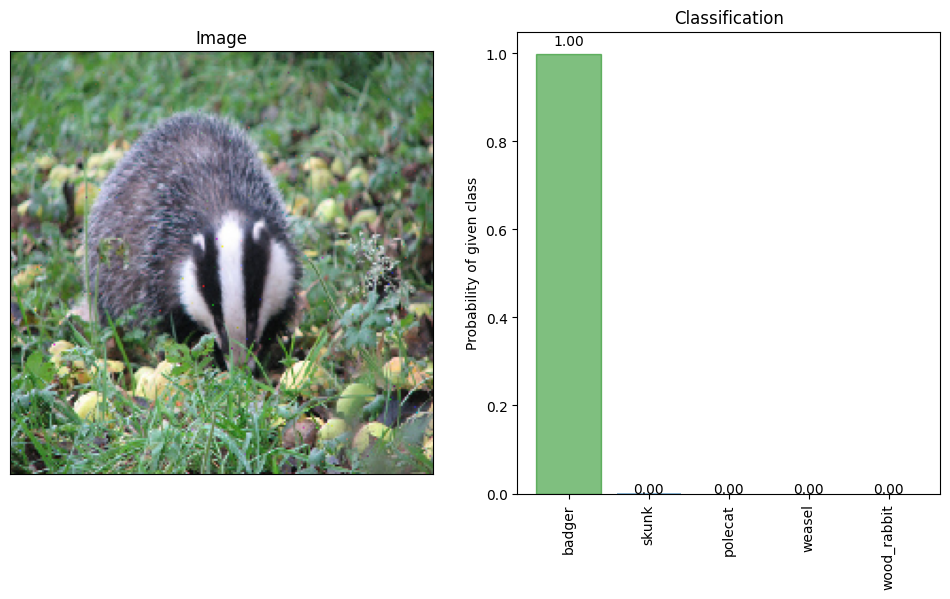

In [ ]:
# deflections on clean image
img_clean_deflected = pixel_deflection_without_map(img_clean, deflections=200, window=10)
_ = classify_images([img_clean_deflected], true_label, visualize=True)

Probability of the true class being **badger** remains at 100%. 
Let's investigate the diff with the clean image.

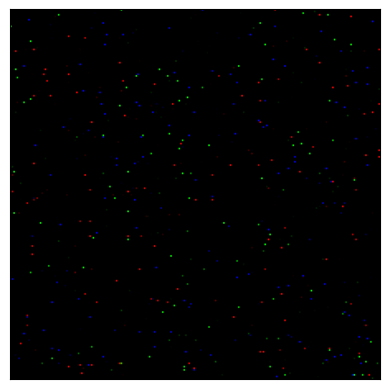

In [ ]:
diff = img_clean - img_clean_deflected
plt.imshow(diff.astype('uint8'))
_=plt.xticks([]), plt.yticks([])

## Impact of increasing number of deflections
Increasing the number of deflections significantly increases the accruacy of the recovery of the true class.

1/1 [==============================] - 0s 337ms/step


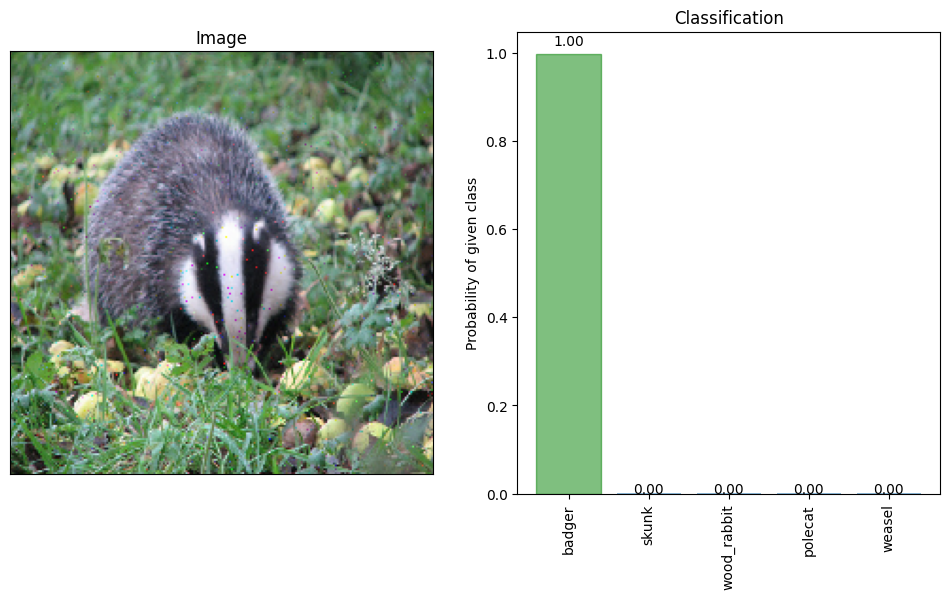

In [ ]:
# More deflections on adversarial image
img_deflected_more = pixel_deflection_without_map(img_adversary, deflections=600, window=10)
_ = classify_images([img_deflected_more], true_label, visualize=True)

Now the accuracy jumps to 75% but it does not change degrade the accuracy on clean image, as shown below.


1/1 [==============================] - 0s 187ms/step


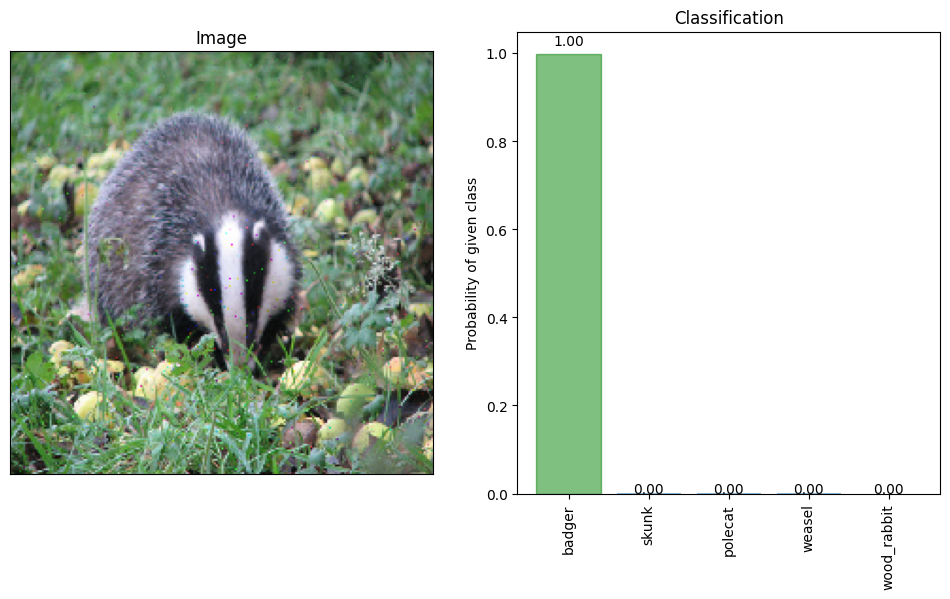

In [ ]:
# More deflections on clean image
img_clean_deflected_more = pixel_deflection_without_map(img_clean, deflections=600, window=10)
_ = classify_images([img_clean_deflected_more], true_label, visualize=True)

# Wavelet Denoiser

In [ ]:
from skimage.restoration import denoise_wavelet
def denoiser(img):
    return denoise_wavelet(img/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0

<ipython-input-31-5ba1368c3bad>:3: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_wavelet(img/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0


1/1 [==============================] - 0s 425ms/step


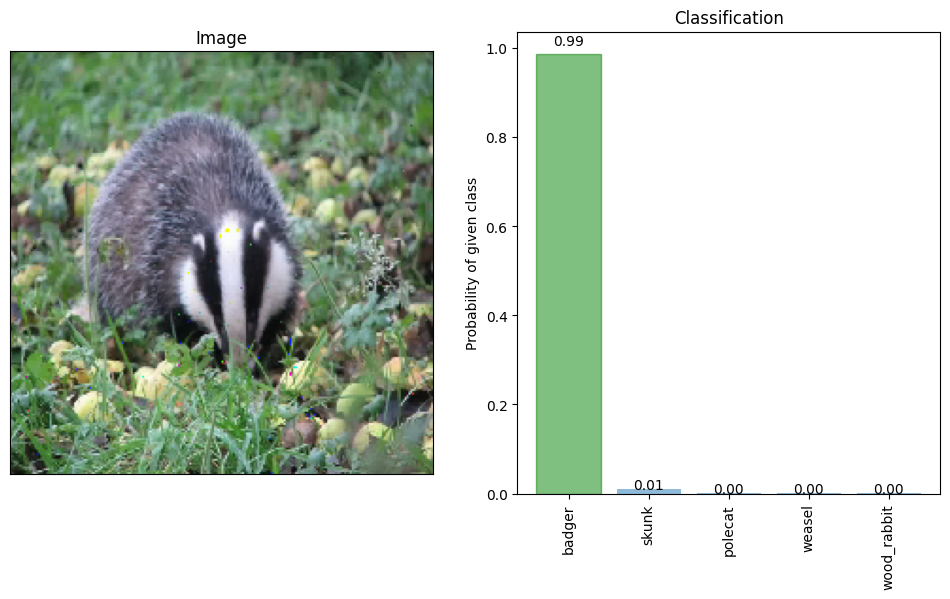

In [ ]:
img_deflected_denoised = denoiser(img_deflected)
_ = classify_images([img_deflected_denoised], true_label, visualize=True)

## Attacks are non-localized

In our paper we analyzed the location of pixels where the adversary add the perturbation and found out that most attacks are agnostic to the presence of semantic objects. The correlation between pixels of class-object and pixels perturbed by attacks is very low. 
Here is the average location of adversarial perturbation for some of the major known attacks:

![distribution_of_attacks](https://i.imgur.com/ydQ0a5e.png)

## Apply R-CAM

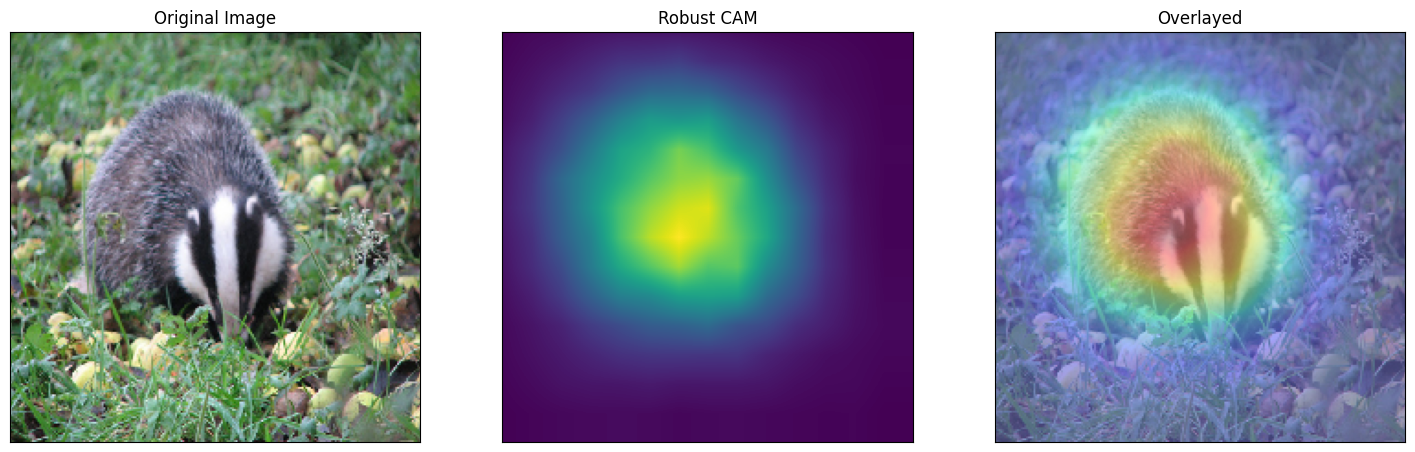

In [ ]:
from matplotlib.pyplot import imread
from matplotlib.colors import Normalize

# We normalize the map, because rcam_prob is treated
# as probability values
rcam_prob = Normalize()(imread('/content/pixel-deflection/maps/n02447366_00008562.png'))

f, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].imshow(img_clean.astype('uint8'))
ax[0].set_title('Original Image')
ax[1].imshow(rcam_prob)
ax[1].set_title('Robust CAM')
ax[2].imshow(rcam_prob, cmap='jet', alpha=0.6)
ax[2].imshow(img_clean.astype('uint8'), alpha=0.4)
ax[2].set_title('Overlayed')
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])


Here is the distribution of the RCAM probabilities:

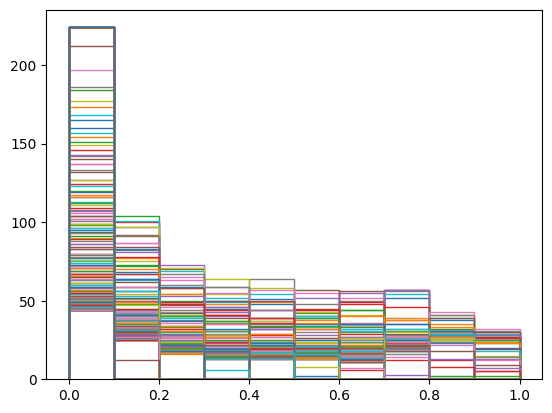

In [ ]:
plt.hist(rcam_prob, bins=10, histtype='step')
plt.show()

## Pixel Deflection with R-CAM

In [ ]:
def pixel_deflection_with_map(img, rcam_prob, deflections, window):
    img = np.copy(img)
    H, W, C = img.shape
    while deflections > 0:
        #for consistency, when we deflect the given pixel from all the three channels.
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            
            # if a uniformly selected value is lower than the rcam probability
            # skip that region
            if uniform(0,1) < rcam_prob[x,y]:
                continue
                
            while True: #this is to ensure that PD pixel lies inside the image
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            # calling pixel deflection as pixel swap would be a misnomer,
            # as we can see below, it is one way copy
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1
    return img

1/1 [==============================] - 0s 211ms/step


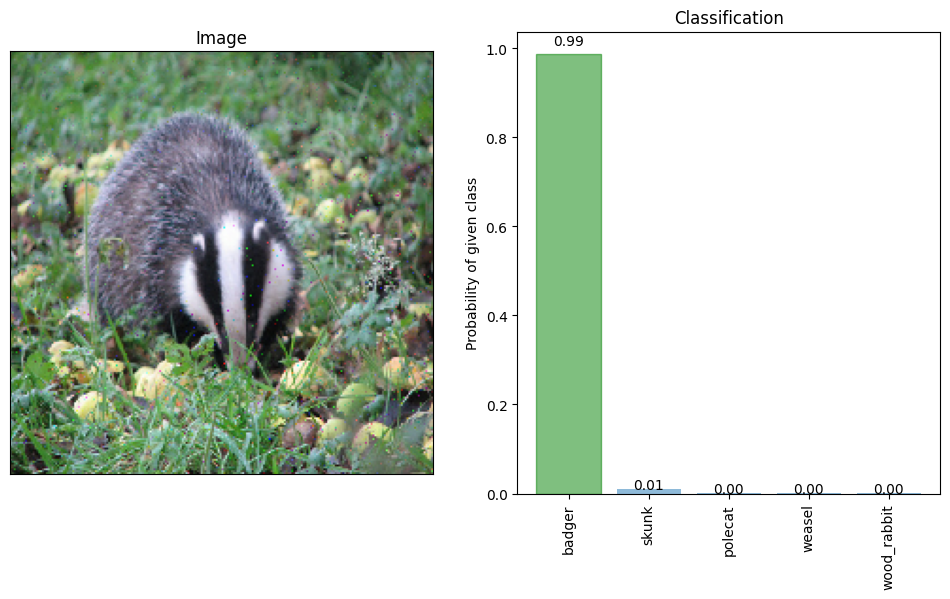

In [ ]:
img_deflected_rcam = pixel_deflection_with_map(img_adversary, rcam_prob, deflections=1500, window=10)
_ = classify_images([img_deflected_rcam], true_label, visualize=True)

## Distribution of Pixel Deflection with RCAM

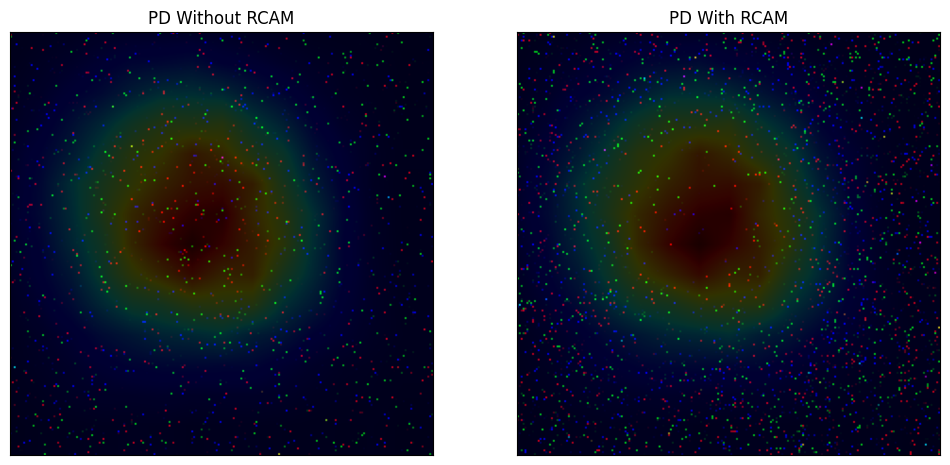

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12, 6))

diff1 = img_adversary - img_deflected_more
ax[0].imshow(diff1.astype('uint8'))
ax[0].imshow(rcam_prob, cmap='jet', alpha=0.2)
ax[0].set_title('PD Without RCAM')

diff2 = img_adversary - img_deflected_rcam
ax[1].imshow(diff2.astype('uint8'))
ax[1].imshow(rcam_prob, cmap='jet', alpha=0.2)
ax[1].set_title('PD With RCAM')

for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])


## Wavelet Denoising after PD with RCAM

<ipython-input-31-5ba1368c3bad>:3: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_wavelet(img/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0


1/1 [==============================] - 0s 198ms/step


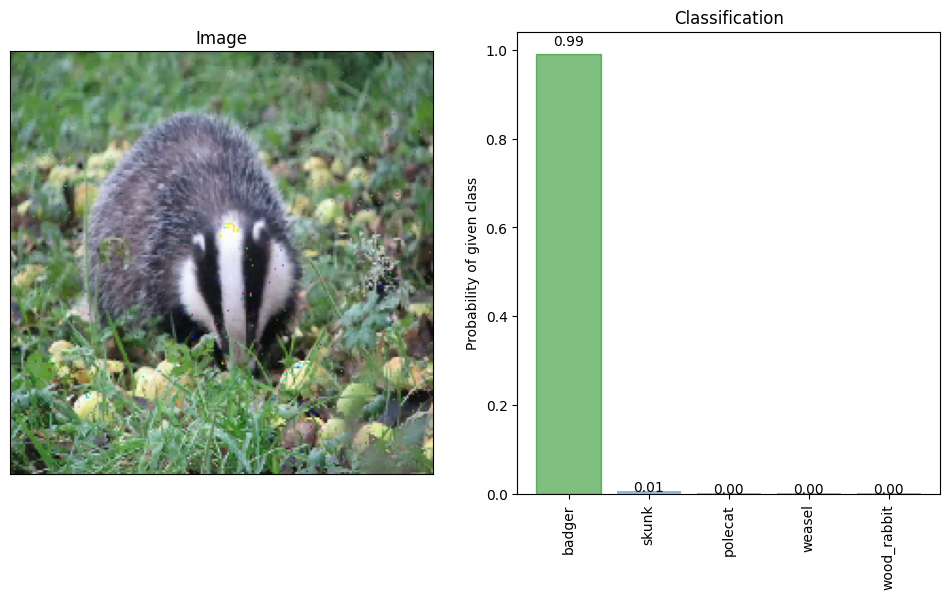

In [ ]:
img_deflected_rcam_denoised = denoiser(img_deflected_rcam)
_ = classify_images([img_deflected_rcam_denoised], true_label, visualize=True)

Now the confidence on the true class being **badger** is $97\%$ and on the adversarial class is $2\%$. This is our best result.

In [ ]:
!python /content/pixel-deflection/main.py

2023-05-09 19:18:11.582609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Image: /content/pixel-deflection/images/n02447366_00008562.png, True Class: 'badger'
Before Defense :
1/1 [==============================] - 1s 1s/step
Predicted Class  badger:0.97 , skunk:0.03 , polecat:0.00 , weasel:0.00 , wood_rabbit:0.00 
After Defense :
/content/pixel-deflection/methods.py:16: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_wavelet(img,sigma=sigma, mode='soft', multichannel=True,convert2ycbcr=True, method='BayesShrink')
1/1 [==============================] - 0s 198ms/step
Predicted Class  badger:0.98 , skunk:0.02 , polecat:0.00 , weasel:0.00 , wood_rabbit:0.00 


In [ ]:
!python /content/pixel-deflection/main.py -process_batch -directory /content/pixel-deflection/images

2023-05-09 19:19:28.438596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/pixel-deflection/methods.py:16: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_wavelet(img,sigma=sigma, mode='soft', multichannel=True,convert2ycbcr=True, method='BayesShrink')
/content/pixel-deflection/methods.py:16: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_wavelet(img,sigma=sigma, mode='soft', multichannel=True,convert2ycbcr=True, method='BayesShrink')
1/1 [==============================] - 2s 2s/step
After recovery Top 1 accuracy is 33.33 and Top 5 accuracy is 100.00
